In [11]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import celloracle as co

In [3]:
print(f"CellOracle version: {co.__version__}")

CellOracle version: 0.20.0


In [4]:
# Visualization settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams['savefig.dpi'] = 300

# Scanpy settings
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white')

In [5]:
save_folder = "figures"
data_folder = "processed_data"
os.makedirs(save_folder, exist_ok=True)
os.makedirs(data_folder, exist_ok=True)

### load & preprocess data

In [6]:
data_dir = "CTR9_snRNASeq"

wt_path = os.path.join(data_dir, "WT", "filtered_feature_bc_matrix.h5")
ko_path = os.path.join(data_dir, "KO", "filtered_feature_bc_matrix.h5")

print(f"WT file exists: {os.path.exists(wt_path)}")
print(f"KO file exists: {os.path.exists(ko_path)}")

WT file exists: True
KO file exists: True


In [7]:
# Load WT data
adata_wt = sc.read_10x_h5(wt_path)
adata_wt.var_names_make_unique()
adata_wt.obs['genotype'] = 'WT'
adata_wt.obs['sample'] = 'WT'
print(f"WT data shape: {adata_wt.shape}")
adata_wt

reading CTR9_snRNASeq/WT/filtered_feature_bc_matrix.h5
 (0:00:00)
WT data shape: (4981, 33696)


AnnData object with n_obs × n_vars = 4981 × 33696
    obs: 'genotype', 'sample'
    var: 'gene_ids', 'feature_types', 'genome'

In [8]:
# Load KO data
adata_ko = sc.read_10x_h5(ko_path)
adata_ko.var_names_make_unique()
adata_ko.obs['genotype'] = 'KO'
adata_ko.obs['sample'] = 'CTR9_KO'
print(f"KO data shape: {adata_ko.shape}")
adata_ko

reading CTR9_snRNASeq/KO/filtered_feature_bc_matrix.h5
 (0:00:00)
KO data shape: (4888, 33696)


AnnData object with n_obs × n_vars = 4888 × 33696
    obs: 'genotype', 'sample'
    var: 'gene_ids', 'feature_types', 'genome'

In [9]:
# Make cell barcodes unique before concatenation
adata_wt.obs_names = [f"WT_{bc}" for bc in adata_wt.obs_names]
adata_ko.obs_names = [f"KO_{bc}" for bc in adata_ko.obs_names]

In [12]:
# Concatenate datasets
adata = ad.concat([adata_wt, adata_ko], join='outer')
adata.obs_names_make_unique()
print(f"Combined data shape: {adata.shape}")
print(f"\nGenotype distribution:")
print(adata.obs['genotype'].value_counts())

Combined data shape: (9869, 33696)

Genotype distribution:
WT    4981
KO    4888
Name: genotype, dtype: int64


### standard preprocessing

... storing 'genotype' as categorical
... storing 'sample' as categorical


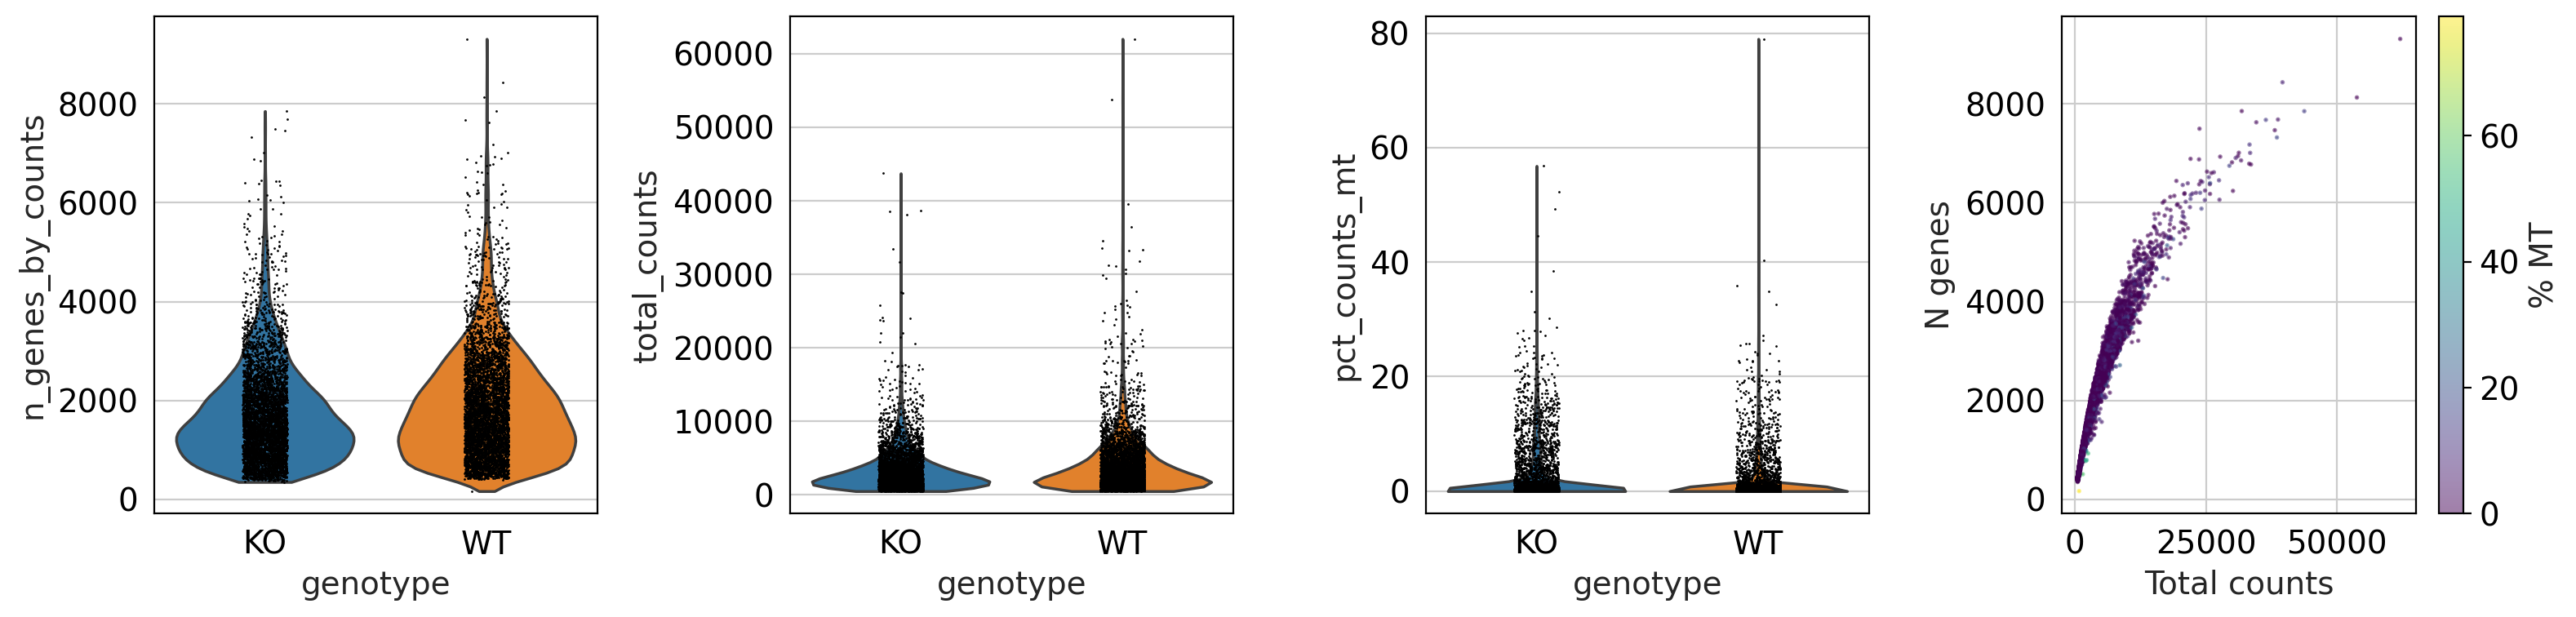

In [13]:
# Calculate QC metrics
# For mouse, mitochondrial genes start with 'mt-' (lowercase)
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Visualize QC metrics
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
sc.pl.violin(adata, 'n_genes_by_counts', groupby='genotype', ax=axes[0], show=False)
sc.pl.violin(adata, 'total_counts', groupby='genotype', ax=axes[1], show=False)
sc.pl.violin(adata, 'pct_counts_mt', groupby='genotype', ax=axes[2], show=False)

# Scatter plot
axes[3].scatter(adata.obs['total_counts'], adata.obs['n_genes_by_counts'], 
                c=adata.obs['pct_counts_mt'], cmap='viridis', s=1, alpha=0.5)
axes[3].set_xlabel('Total counts')
axes[3].set_ylabel('N genes')
plt.colorbar(axes[3].collections[0], ax=axes[3], label='% MT')

plt.tight_layout()
plt.savefig(f"{save_folder}/QC_metrics.png", dpi=300, bbox_inches='tight')
plt.show()